In [6]:
import pickle

import numpy as np
import pandas as pd

from astroExplain.spectra.explanation import TellMeWhy
from sdss.metadata import MetaData
from anomaly.constants import GALAXY_LINES

meta = MetaData()
%matplotlib inline

In [2]:
bin_id = "bin_04"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"


## Explore common anomalies of different scores

### $L^p$ scores

In [3]:
intersection_directory = f"{explanations_directory}/intersections"
specobjid_common_anomalies = np.load(f"{intersection_directory}/specobjid_lp_intersection_1000.npy")

Get heat map of explanation


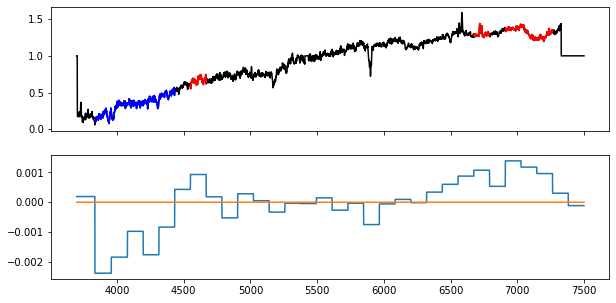

In [16]:
with open(f"{intersection_directory}/mse_filter_250Kms_noRel100/00000/{specobjid_common_anomalies[0]}.pkl", "rb") as file:

    explanation = pickle.load(file)
    why = TellMeWhy(wave=wave, explanation=explanation)
    
_, positive_spectrum = why.positive_mask_and_segments()
_, negative_spectrum = why.negative_mask_and_segments()
weights_explanation = why.get_heatmap()

fig, axs = why.plot_full_explanation()

for ax in axs: ax.clear()

axs[0].plot(why.wave, why.galaxy, c="black")
axs[0].plot(why.wave, positive_spectrum, c="red")
axs[0].plot(why.wave, negative_spectrum, c="blue")

axs[1].plot(why.wave, weights_explanation)
axs[1].plot(why.wave, np.zeros(why.wave.shape))

Get heat map of explanation


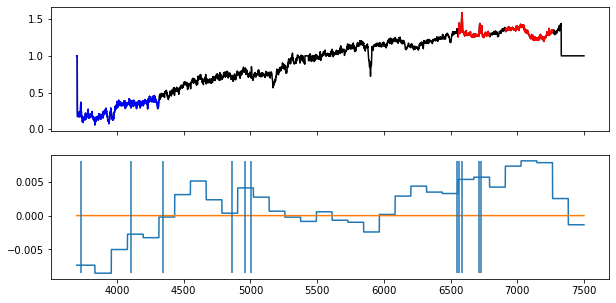

In [12]:
with open(f"{intersection_directory}/lp_filter_250Kms_noRel100/00000/{specobjid_common_anomalies[0]}.pkl", "rb") as file:

    explanation = pickle.load(file)
    why = TellMeWhy(wave=wave, explanation=explanation)
    
_, positive_spectrum = why.positive_mask_and_segments()
_, negative_spectrum = why.negative_mask_and_segments()
weights_explanation = why.get_heatmap()

fig, axs = why.plot_full_explanation()

for ax in axs: ax.clear()

axs[0].plot(why.wave, why.galaxy, c="black")
axs[0].plot(why.wave, positive_spectrum, c="red")
axs[0].plot(why.wave, negative_spectrum, c="blue")

axs[1].plot(why.wave, weights_explanation)
axs[1].plot(why.wave, np.zeros(why.wave.shape))
axs[1].vlines(GALAXY_LINES.values(), ymin=weights_explanation.min(), ymax=weights_explanation.max())

Get heat map of explanation


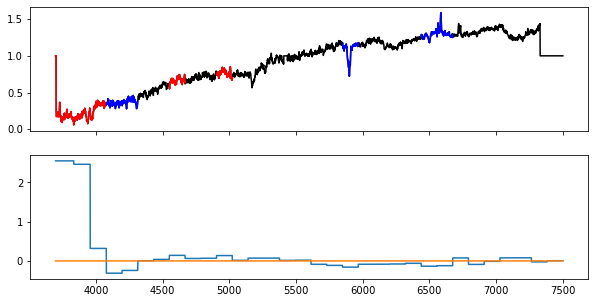

In [27]:
with open(f"{intersection_directory}/lp_filter_250Kms_rel100/00000/{specobjid_common_anomalies[0]}.pkl", "rb") as file:

    explanation = pickle.load(file)
    why = TellMeWhy(wave=wave, explanation=explanation)
    
_, positive_spectrum = why.positive_mask_and_segments()
_, negative_spectrum = why.negative_mask_and_segments()
weights_explanation = why.get_heatmap()

fig, axs = why.plot_full_explanation()

for ax in axs: ax.clear()

axs[0].plot(why.wave, why.galaxy, c="black")
axs[0].plot(why.wave, positive_spectrum, c="red")
axs[0].plot(why.wave, negative_spectrum, c="blue")

axs[1].plot(why.wave, weights_explanation)
axs[1].plot(why.wave, np.zeros(why.wave.shape))

Get heat map of explanation


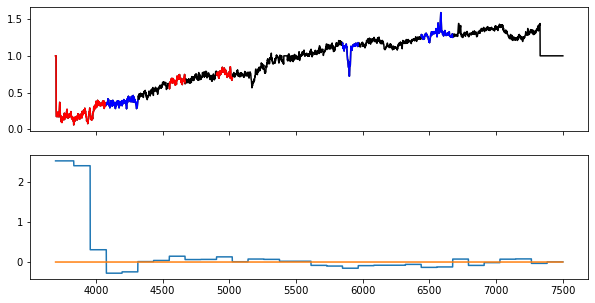

In [18]:
with open(f"{intersection_directory}/lp_rel100/00000/{specobjid_common_anomalies[0]}.pkl", "rb") as file:

    explanation = pickle.load(file)
    why = TellMeWhy(wave=wave, explanation=explanation)
    
_, positive_spectrum = why.positive_mask_and_segments()
_, negative_spectrum = why.negative_mask_and_segments()
weights_explanation = why.get_heatmap()

fig, axs = why.plot_full_explanation()

for ax in axs: ax.clear()

axs[0].plot(why.wave, why.galaxy, c="black")
axs[0].plot(why.wave, positive_spectrum, c="red")
axs[0].plot(why.wave, negative_spectrum, c="blue")

axs[1].plot(why.wave, weights_explanation)
axs[1].plot(why.wave, np.zeros(why.wave.shape))

In [13]:
meta.get_sky_server_url(specobjid_common_anomalies[0])

'http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=919963892807919616&apid='